# Read data

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns
import numpy as np

In [71]:
# replace this with the file path on your computer
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)

In [72]:
# don't touch the original df
# df = original_df.copy()

In [73]:
target_classes = df['STAT_CAUSE_DESCR'].unique()

In [74]:
target_classes

array(['Miscellaneous', 'Arson', 'Debris Burning', 'Smoking', 'Campfire',
       'Equipment Use', 'Powerline', 'Lightning', 'Railroad', 'Children',
       'Fireworks', 'Structure'], dtype=object)

In [75]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Null columns

In [76]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


In [77]:
# null_columns = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
#                 'FIRE_CODE', 'FIRE_NAME',
#                 'ICS_209_INCIDENT_NUMBER',  'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
#                 'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
#                 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']

# we will not encode all of them, just encode these:
null_features = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
                         'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                         'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
                         'COUNTY', 'FIPS_CODE', 'FIPS_NAME']



There are five columns that are 99% null, from EDA section, we see that if they are not null, it will help with the prediction of some columns.  
For other features, it seems like encode them as null or not null both have benefits.

In [78]:
# fucntion that will encode this four columns
def null_encoding(df):
  # these columns will be encoded as 1 - null, 0 - not null
  for feature in null_features:
    df['NE-'+feature] = df[feature].isnull().astype(int)
  return df


Little note here: we tried to pass some columns with empty values to the model, since XGB is able to fill in te blank. However, the train error will be lower but the validation error is higher.

# Geo Spacial data

## Longitude and latitude

Let's just try pass in the numbers and see how much it imporves the result. The result is pretty good. We add another hald percent.  



Now we will cluster the points using DBSCAN, and then calculate the distance of each point to it's nearest cluster. (Distance to centroid of the cluster).  We will do this also group by each target class in the target

In [79]:
from sklearn.cluster import DBSCAN

target_class_clusters = {}
def get_clusters_centroids(df):
  epsilon = 0.5  # maximum distance between points to be considered in the same neighborhood
  min_samples = 5  # minimum number of points in a neighborhood to be considered a core point
  dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
  # now apply DBSCAN
  dbscan.fit(df[['LATITUDE', 'LONGITUDE']])
  # Get the indices of core samples
  core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
  core_samples_mask[dbscan.core_sample_indices_] = True
  # Get the unique cluster labels
  labels = dbscan.labels_
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  # Now Calculate the cluster centroids
  clusters_centroids = []
  for i in range(n_clusters):
      cluster_points = df[['LATITUDE', 'LONGITUDE']][labels == i]
      cluster_center = np.mean(cluster_points, axis=0)
      clusters_centroids.append(cluster_center)
  clusters_centroids = np.array(clusters_centroids)
  return clusters_centroids

def train_target_class_clusters(df):
  for target_class in target_classes:
    df_target_class = df[df['STAT_CAUSE_DESCR']== target_class]
    target_class_clusters[target_class] = get_clusters_centroids(df_target_class)


In [80]:
def encode_dis_to_nearest_centroid(row, target_class):
  clusters_centroids = target_class_clusters[target_class]
  point = [row['LATITUDE'], row['LONGITUDE']]
  cluster_distances = np.linalg.norm(clusters_centroids - point, axis=1)  # Calculate distances to all centroids at once
  min_distance = np.min(cluster_distances)  # Find the minimum distance
  return min_distance



## STATE

During the EDA we found out that being in certain state will affect the distribution of the final label. So what we are going to do is that, for each label, we will find the top k states that is highly correlated to the label, and we will generate a feature that says "is the sample in either of these k states".

In [81]:
state_significance = {}

def train_state_encoders(df):
  # find out for each class which states will have higher than normal percentage of the class instance.
  percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
  cross_Vals = pd.crosstab(df['STATE'], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)

  # For each class, we will encode each state to "how important they are to prediction the class"
  for target_class in target_classes:
    state_significance_per_class = {}
    for state in cross_Vals.index:
      significance = cross_Vals.loc[state, target_class]
      state_significance_per_class[state] = significance
    state_significance[target_class] = state_significance_per_class




## COUNTY

There are some missing values in county. And we can see that county-fip_code-fip_name are being null together.   
Also we can see that county being null have a negative influence on powerline and rail road.  
So what if we pass FIPS_code into frequency encoding?  
Turns out it helped..... I don't even understand why it would help.....


So what if we imputate county by state, and then encode it. See what would happen?  
Turns out if you don't imputate, it preforms better.... XGBoost seems to know how to handle it.....

In [82]:
def encode_geospacial_data(df):
  # encode state
  for target_class in target_classes:
    df['SE-'+ target_class] = df['STATE'].map(state_significance[target_class])

  # imputate county: doesn't help with perfomrance
  # df["COUNTY"] = df["COUNTY"].str.lower()
  # df.loc[df['COUNTY'].isnull(), 'COUNTY'] = df.loc[df['COUNTY'].isnull(),'STATE']

  # encode longitude and latitude
  for target_class in target_classes:
    df['DISTANCE_TO_CLUSTERS-'+target_class] = df.apply(encode_dis_to_nearest_centroid,args=(target_class,), axis=1)
  return df

In [83]:
train_df = pd.concat([X_train, y_train], axis=1)
train_state_encoders(train_df)
train_target_class_clusters(train_df)

In [84]:
state_encoding_features = ['SE-' + target_class for target_class in target_classes]
coordinate_encoding_features = ['DISTANCE_TO_CLUSTERS-'+target_class for target_class in target_classes]
geospacial_features = state_encoding_features + ['LATITUDE', 'LONGITUDE'] + coordinate_encoding_features

# Numerical

## ID Columns

There are three not null ID columns: 'OBJECTID', 'FOD_ID', 'FPA_ID'  
Object id and FOD id should not contain any information, if they do, then it's probably leakage?  
Let's try to add them to the model and see if it helps.
At first glance doesn't really help.

In [85]:
id_columns = ['OBJECTID', 'FOD_ID', 'FPA_ID']


## Fire Size

First try just add in FIRE_SIZE and see what happens: It doesn't help much, we will keep it. Taking the log doesnot really improve it either.

# Time data

## Date, Month, Season

Let's first convert the time to the right format

From EDA we have seen that season, month and day of week really affects the final prediction. So we will add in this data.

In [86]:
# target_classes = df['STAT_CAUSE_DESCR'].unique()
# # Create a figure and axes for the subplots
# fig, axes = plt.subplots(4, 3, figsize=(12, 9))

# # Flatten the axes array for easier iteration
# axes = axes.flatten()

# for i, target_class in enumerate(target_classes):
#   target_class_df = df[df['STAT_CAUSE_DESCR'] == target_class]
#   target_class_counts = target_class_df.groupby(df['DISCOVERY_DOY']).size()
#   target_class_counts.plot(kind='bar', color='blue', ax=axes[i])
#   axes[i].set_title(target_class)
#   axes[i].set_xticks([])
#   axes[i].set_xlabel('')


# plt.show()

The first thing we want to check is the obvious ones:  Firework on July the forth. Alone with Miscellaneous, Children and Campfire.

The second thing is we can see that Arson, debris buring, railroad and children have more instances in april. While Lighning and equipment use have more instances in July. Maybe I should try one hot encoding and frequency encoding on month and season.

We also looked at FIRE_YEAR

Little note here: if we have more time, we can see the correlation between two joint features: (feature_1 = a X feature_2 = b). To be more precise: Summer in Alaska. Somethings like this.   
Another little note, I was planning to put some catagorical data in for XGBoost to do some one hot embedding, but turns out that some fatures (season) will make the overall performance lowers.....  
One more thing we can do is preform a cyclic transformation of week of day or even day of year.

In [87]:
import numpy as np

def time_encoding(df):
  # simple reformatting
  df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M', errors='coerce')
  df['CONT_DATE']= pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format='%H%M', errors='coerce')
  # encode independence day
  df['independence_day'] = (df['DISCOVERY_DATE'].dt.month == 7) & (df['DISCOVERY_DATE'].dt.day.isin([4, 5]))

  # encode month and day of week (weekend or not.)
  df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%B')
  df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%A')
  # notice that these two columns will be frequency encoded in the later section. So the later section depends on the execution of this section.

  # I want to pass fire year as a catagory, just like month and day of week, for onhot encoding
  df['FIRE_YEAR'] = df['FIRE_YEAR'].astype('category')

  # Now I want to see if I can stuff in one more thing: Season. Basically a combination of months.
  # And I will both one hot encode it and frequency encode it
  df['SEASON'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                                          5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                          9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
  # For null time data: Discovery time, control date, control time etc.
  # encode discovery time
  df['DISCOVERY_HOUR'] = df['DISCOVERY_TIME'].dt.hour

  # encode delta time
  df['DISCOVERY_DATETIME'] = pd.to_datetime(df['DISCOVERY_DATE'].astype(str) + ' ' + df['DISCOVERY_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')


  df['CONT_DATETIME'] = pd.to_datetime(df['CONT_DATE'].astype(str) + ' ' + df['CONT_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')

  # Calculate the time difference
  df['DELTA_TIME'] = (df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']).dt.total_seconds()

  # Cyclic transformation for DOY, Month, Week, Hour
  df['SIN_DISCOVERY_DOY'] = np.sin(2*np.pi*df['DISCOVERY_DOY']/366)
  df['COS_DISCOVERY_DOY'] = np.cos(2*np.pi*df['DISCOVERY_DOY']/366)

  df['SIN_MONTH'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)
  df['COS_MONTH'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)

  df['SIN_DAY_OF_WEEK'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)
  df['COS_DAY_OF_WEEK'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)

  df['SIN_HOUR'] = np.sin(2*np.pi*df['DISCOVERY_HOUR']/24)
  df['COS_HOUR'] = np.cos(2*np.pi*df['DISCOVERY_HOUR']/24)

  return df

In [88]:
DELTA_TIME_means_by_class_map = {}
def fill_missing(row):
    if pd.isna(row['DELTA_TIME']):
        return DELTA_TIME_means_by_class_map[row['FIRE_SIZE_CLASS']]
    else:
        return row['DELTA_TIME']
def imputate_DELTA_TIME(df):
  df['DELTA_TIME'] = df.apply(fill_missing, axis=1)
  return df

In [89]:
def train_DELTA_TIME_IMPUTATOR(df):
  global DELTA_TIME_means_by_class_map
  DELTA_TIME_means_by_class_map = df.groupby('FIRE_SIZE_CLASS')['DELTA_TIME'].agg(['mean'])['mean'].to_dict()

turns out imputation doesnot affect it at all.

In [90]:
encoded_time_data = ['independence_day', 'MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'DISCOVERY_HOUR', 'DELTA_TIME',
                     'SIN_DISCOVERY_DOY', 'COS_DISCOVERY_DOY', 'SIN_MONTH', 'COS_MONTH',
                     'SIN_DAY_OF_WEEK', 'COS_DAY_OF_WEEK', 'SIN_HOUR', 'COS_HOUR']

## Null Time Data

It seems like some of the descovery time and contained time are null. In order to solve this problem, denote delta_time = contained_time - discover_time. We can see that there are correlation between delta_time and fire_size, so maybe we can try to imputate this value.   
In EDA, we can see that descovery time and contained time being null have high correlation. So if both time is mising, we can try to drop the rows, and see what would happen.

In [91]:
# not used
def drop_null_time_rows(X, y):
  df = X
  df['STAT_CAUSE_DESCR'] = y
  df = df.dropna(subset=['DISCOVERY_TIME']).copy()
  y = df['STAT_CAUSE_DESCR']
  X = df.drop(columns=['STAT_CAUSE_DESCR'])
  return X, y

It seems like if not drop null rows, XGBoost will preform slightly better by fill in the blank by itself.

Now there are two thing we want to do, first, we want to encode the discovery_time, and then we want to calculate delta time.  
I am thinking for starters, I will encode the discovery time into hours of the day, and preform a cyclic transformation.

The observation is, cyclic transformation on hour doesnot really help with accuracy.

Let's first try to see if we just pass in DISCOVERY_HOUR and DELTA_TIME, what would happen.   
Turns out it helps the model by a little bit.

Finally to add something, we will just add cyclic transformation for DOY, MONTH, Week, Hour, and see what happens

And one more thing: we will imputate the DELTA_TIME by the average of the fire size class. See EDA

# Catagorical

We will try to use frequency encoding for every thing. Except for null columns and states.

In [92]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']
LC_features = ['FIRE_SIZE_CLASS',
                'NWCG_REPORTING_AGENCY',
                'OWNER_CODE', 'OWNER_DESCR',
                'SOURCE_SYSTEM', 'SOURCE_SYSTEM_TYPE',]
catagorical_time_data = ['MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'SEASON', 'DISCOVERY_HOUR']
catagorical_geospacial_data = ['STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']
catagorical_features = HC_features + LC_features + catagorical_time_data + catagorical_geospacial_data

In [93]:
#  generic function for frequency encoding
from sklearn.preprocessing import LabelEncoder
frequency_encoder_map = {}
def train_frequency_encoders(df):
  for feature in catagorical_features:
    frequency_encoder = df[feature].value_counts(normalize=True)
    frequency_encoder_map[feature] = frequency_encoder

def frequency_encoding(df):
  for feature in catagorical_features:
    le = frequency_encoder_map[feature]
    df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
  return df

Little note here: if just simply pass catagorical data to to XGB will not make it better. I am assuming XGB is using one hot embedding.

# Additional information

In [94]:
df_stormevents = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/storm_events.csv',index_col=0)

In [95]:
# train storm encoder, we will just look at first day of storm
df_stormevents['BEGIN_DATE'] = pd.to_datetime(df_stormevents['BEGIN_DATE'])
storm_by_state = df_stormevents.groupby(['BEGIN_DATE', 'STATE']).groups.keys()

def encode_storm_data(df):
  df['STORM'] = False
  df['STORM'] = df.apply(lambda row: (row['DISCOVERY_DATE'],
                                    row['STATE']) in storm_by_state if row['STATE'] else None, axis=1)
  return df

# XGBoost

## Preparation

In [96]:
# select features for trainin: This list depends on feature engineering
encoded_catagorical_features = ['FE-' + feature for feature in catagorical_features]
encoded_null_features = ['NE-'+ feature for feature in null_features]
selected_features = encoded_catagorical_features + encoded_null_features + geospacial_features + ['FIRE_SIZE']+ encoded_time_data +['STORM']

In [97]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(y)
def transform_data_for_XGB(X, y, train = False):
  # encode y
  y = target_encoder.transform(y)

  # null encoding: notice: encode null first because we might do some imputation later.
  X = null_encoding(X)

  # encode time data
  X = time_encoding(X)

  # encode geospacial data
  X = encode_geospacial_data(X)

  if train==True:
    # train the frequency encoders
    train_frequency_encoders(X)

  # frequency encoding: notice: frequency encoding at the end!
  X = frequency_encoding(X)

  # additional imforamtion: encode storm information: Notice: have to be after time encoding
  X = encode_storm_data(X)

  # select feature for training
  X = X[selected_features]

  # change "object" dtypes to "category" types
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})
  return X, y


In [98]:
X_train, y_train = transform_data_for_XGB(X_train, y_train, train=True)
X_val, y_val = transform_data_for_XGB(X_val, y_val)

In [99]:
# save the files to drive, so that we can switch to GPU
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
dump_file(y_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
dump_file(X_val,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
dump_file(y_val, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
dump_file(target_encoder, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


## Training (Can switch to GPU)

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
sample_weights = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/sample_weights')

In [2]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    # "tree_method": "hist",
    "device": "cuda",
    "enable_categorical": True,
    # "eval_metric": auc_ovr,
    #  "n_estimators": 2,
    # "max_cat_to_onehot": 4
    # "colsample_bylevel": 0.7,
    # 'objective':'multi:softmax',  # for multi-class classification
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:2.02332	validation_1-mlogloss:2.02584
[1]	validation_0-mlogloss:1.83757	validation_1-mlogloss:1.84275
[2]	validation_0-mlogloss:1.71711	validation_1-mlogloss:1.72411
[3]	validation_0-mlogloss:1.63244	validation_1-mlogloss:1.64144
[4]	validation_0-mlogloss:1.56858	validation_1-mlogloss:1.57952
[5]	validation_0-mlogloss:1.52065	validation_1-mlogloss:1.53328
[6]	validation_0-mlogloss:1.48242	validation_1-mlogloss:1.49679
[7]	validation_0-mlogloss:1.45169	validation_1-mlogloss:1.46785
[8]	validation_0-mlogloss:1.42736	validation_1-mlogloss:1.44517
[9]	validation_0-mlogloss:1.40720	validation_1-mlogloss:1.42700
[10]	validation_0-mlogloss:1.39021	validation_1-mlogloss:1.41185
[11]	validation_0-mlogloss:1.37485	validation_1-mlogloss:1.39831
[12]	validation_0-mlogloss:1.36299	validation_1-mlogloss:1.38825
[13]	validation_0-mlogloss:1.35186	validation_1-mlogloss:1.37893
[14]	validation_0-mlogloss:1.34215	validation_1-mlogloss:1.37112
[15]	validation_0-mlogloss:1.33404	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [3]:
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')


## Evaluation

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
target_encoder = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')


In [2]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')

In [3]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for Each Class')
  plt.legend(loc='lower right')
  plt.show()

In [4]:
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.862539259465823

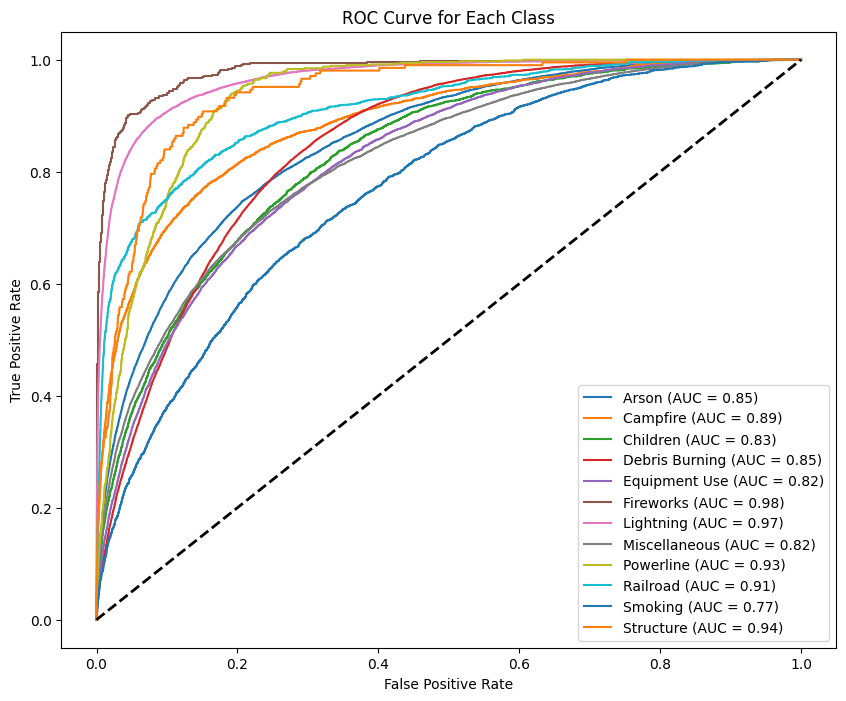

In [5]:
plot_auc_by_class(y_val, y_pred_prob)